In [497]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.set_option('display.max_colwidth', -1)

import warnings
warnings.simplefilter('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,KFold,cross_val_score,cross_val_predict,StratifiedKFold
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.metrics import f1_score,classification_report,plot_confusion_matrix,confusion_matrix

In [498]:
train = pd.read_csv("train_LZdllcl.csv")
test  = pd.read_csv("test_2umaH9m.csv")
train_df = train.copy()
test_df = test.copy()

In [499]:
train.shape, test.shape

((54808, 14), (23490, 13))

In [500]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  KPIs_met >80%         54808 non-null  int64  
 11  awards_won?           54808 non-null  int64  
 12  avg_training_score    54808 non-null  int64  
 13  is_promoted           54808 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.9+ MB


In [501]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23490 entries, 0 to 23489
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           23490 non-null  int64  
 1   department            23490 non-null  object 
 2   region                23490 non-null  object 
 3   education             22456 non-null  object 
 4   gender                23490 non-null  object 
 5   recruitment_channel   23490 non-null  object 
 6   no_of_trainings       23490 non-null  int64  
 7   age                   23490 non-null  int64  
 8   previous_year_rating  21678 non-null  float64
 9   length_of_service     23490 non-null  int64  
 10  KPIs_met >80%         23490 non-null  int64  
 11  awards_won?           23490 non-null  int64  
 12  avg_training_score    23490 non-null  int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 2.3+ MB


**Hypothesis Generation**

Hypothesis is basically an assertion or a statement that you believe is True, you basically use the data provided to judge the veracity of your claim.

Hypothesis Generation is usually done before looking at the data, following are the Hypotheses that can be generated,
1. Employee with high previous years rating has higher chance of being promoted.
2. Employee who has met most of the Key Performance Indicators has higher chance of being promoted.
3. Employee who has a high training score has higher chance of being promoted.
4. Employee who has won an award has high chance of getting promoted.
5. Employee with a PhD or a Master degree has a higher chance of getting promoted as compared to a graduate.

These are only a few of the hypotheses that can be generated, in real life, there may be hundreds of hypotheses that can be generated. 

#### EDA

Following is the process of performing Exploratory Data Analysis,

1. Univariate EDA, looking at one variable at a time.
2. Bi-Variate Analysis, looking at two variables at a time.
3. Looking at the dependent variable relationship with independent variables.

In [502]:
train.head(3)

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0


In [503]:
test.head(3)

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
0,8724,Technology,region_26,Bachelor's,m,sourcing,1,24,NaN,1,1,0,77
1,74430,HR,region_4,Bachelor's,f,other,1,31,3.0,5,0,0,51
2,72255,Sales & Marketing,region_13,Bachelor's,m,other,1,31,1.0,4,0,0,47


In [504]:
# Separating categorical and numerical columns for easier EDA
cat_cols = ['department','region','education','gender','recruitment_channel']
num_cols = ['no_of_trainings','age','previous_year_rating','length_of_service','KPIs_met >80%','awards_won?','avg_training_score']

In [505]:
# Let's check missing values
print ("Following Columns have missing values in Training Dataset:{}".format(list(train.isna().sum()[train.isna().sum()>0].index)))
print ("Following Columns have missing values in Testing Dataset:{}".format(list(test.isna().sum()[test.isna().sum()>0].index)))

Following Columns have missing values in Training Dataset:['education', 'previous_year_rating']
Following Columns have missing values in Testing Dataset:['education', 'previous_year_rating']


We can see that Education and Previous_year_rating columns have missing values. One possible reason for missing values in Previous_year_rating could be that the concerned employee has joined the company only this year and hence there are missing values. This has to be explored further. 

#### Target Variable

In [506]:
train['is_promoted'].value_counts(dropna=False)/len(train)

0    0.91483
1    0.08517
Name: is_promoted, dtype: float64

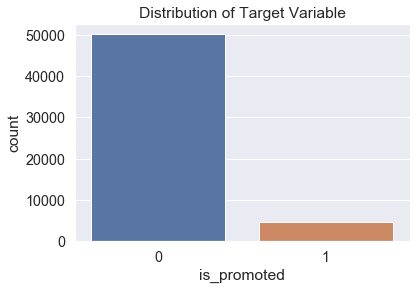

In [507]:
sns.countplot(train['is_promoted']);
plt.title("Distribution of Target Variable");

We can see that the data is highly imbalanced, i.e., very few employees are promoted (around 8.5%)

#### Categorical Variables

In [508]:
# Let's check the number of unique values in the categorical variables.
for col in cat_cols:
    print ("{} column has {} number of unique values:".format(col,train[col].nunique()))

department column has 9 number of unique values:
region column has 34 number of unique values:
education column has 3 number of unique values:
gender column has 2 number of unique values:
recruitment_channel column has 3 number of unique values:


We can see only region column has high cardinality (number of unique values), other columns have fewer unique values. 

In [509]:
# Let's check the categorical columns

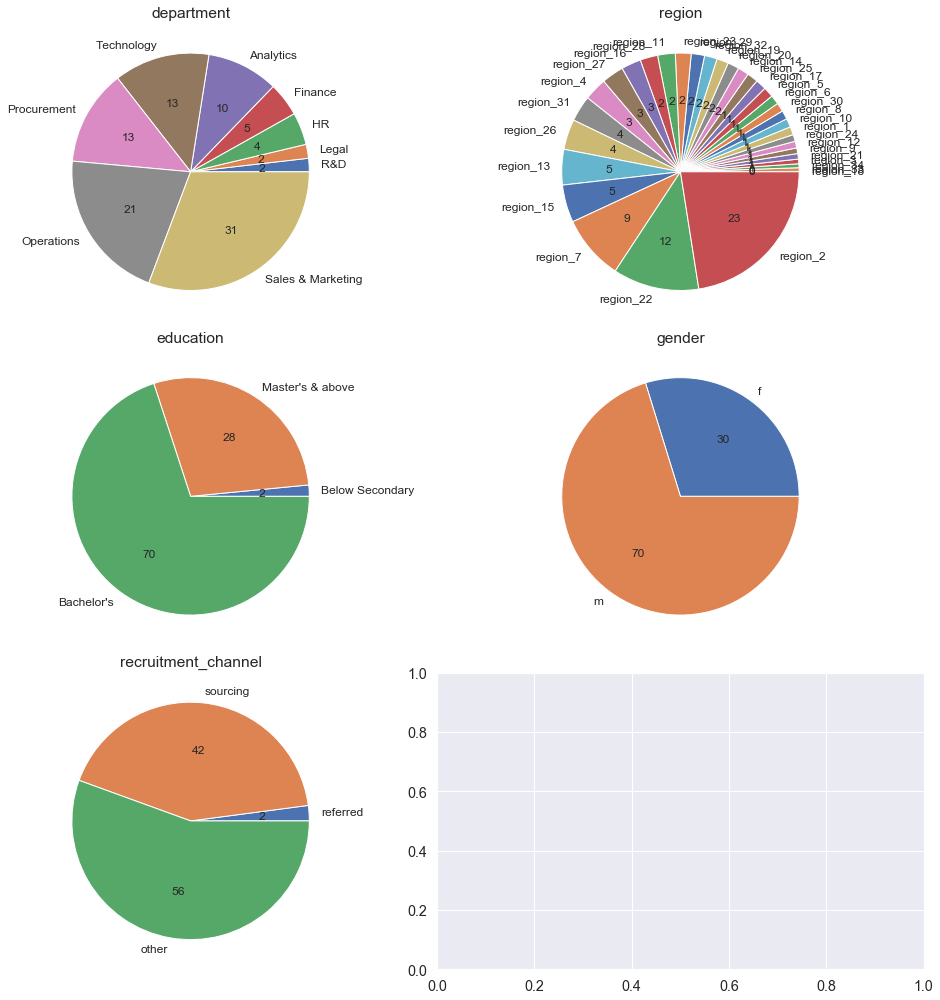

In [510]:
fig, axes = plt.subplots(3, 2, figsize=(14, 14))
axes = [ax for axes_row in axes for ax in axes_row]

for i, c in enumerate(train[cat_cols]):
    _ = train[c].value_counts()[::-1].plot(kind = 'pie', ax=axes[i], title=c, autopct='%.0f', fontsize=12)
    _ = axes[i].set_ylabel('')
    
_ = plt.tight_layout()

Following are the observations from the pie charts above. 

1. recruitment_channel "other" seem to be more popular than referrals and sourcing.
2. Most of the employees hold a Bachelor's degree followed by Master's and above, very few are secondary or below education.
3. Ratio of Male to Female employees is 7:3.
4. Sales&Marketing, Operations and Procurement seem to be the popular departments. 
5. As we have seen already, region has a lot of unique values, but regions 2, 22 and 7 seem to be more popular. 

In [511]:
# Let's check the distribution of the dependent variable according to the independent categorical variables

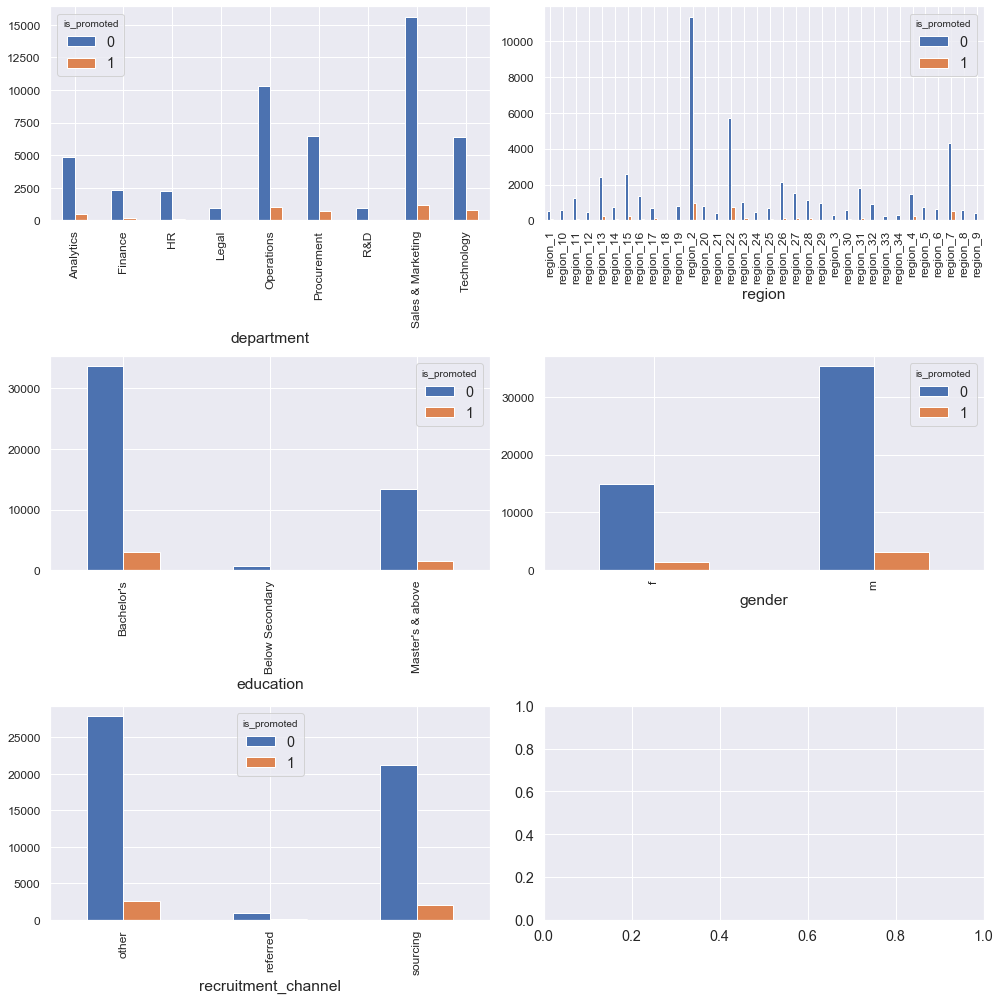

In [512]:
fig, axes = plt.subplots(3, 2, figsize=(14, 14))
axes = [ax for axes_row in axes for ax in axes_row]

for i, c in enumerate(train[cat_cols]):
    _ = train.groupby(c)['is_promoted'].value_counts(dropna=False).unstack().plot(kind ='bar',ax=axes[i],fontsize=12)
    _ = axes[i].set_ylabel('')
    
_ = plt.tight_layout()

Following are the observations from the bar charts above. 

1. If you are Below Secondary level educated, your chances of promotion are minuscule.
2. We can see tat although Males dominate the employees, if you are a female employee, you stand good chance of getting promoted. 
3. If your education level is Master's and above, you have good chance of getting promoted.

In [513]:
# Let's see the mean of the dependent variable by education level

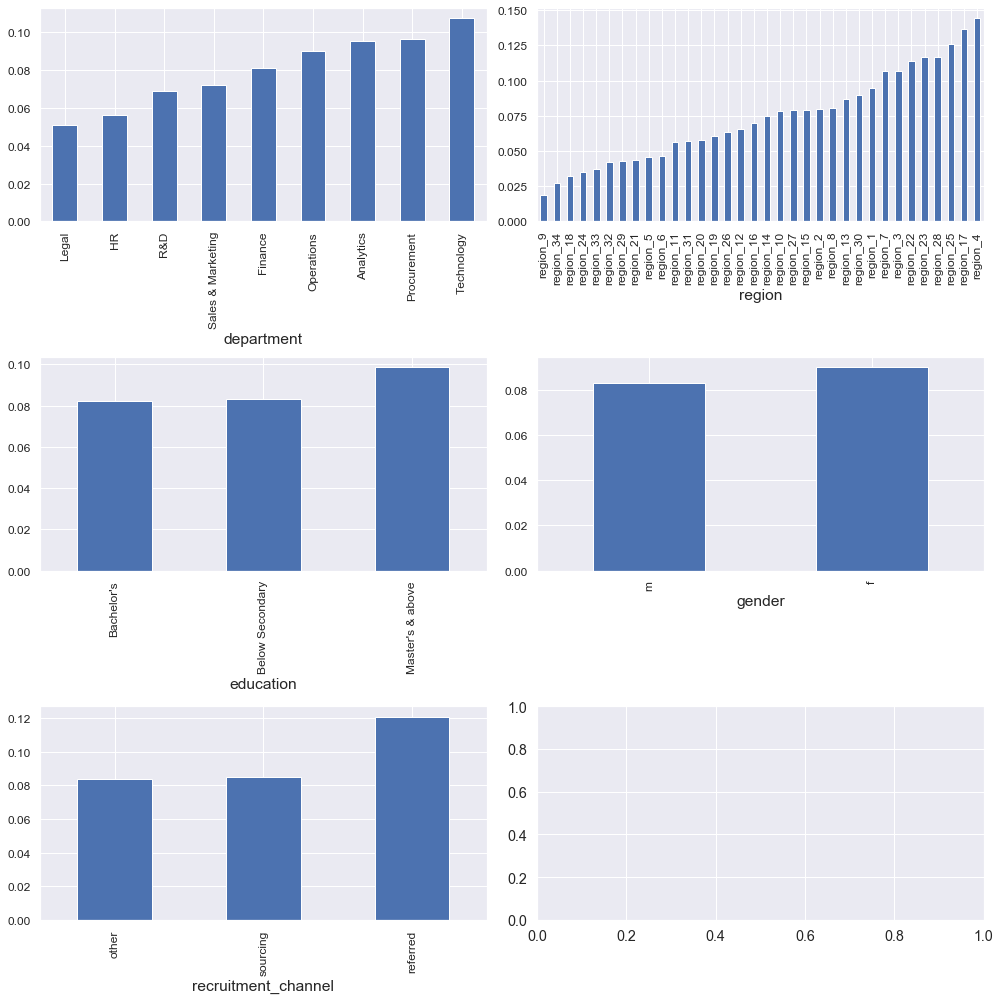

In [514]:
fig, axes = plt.subplots(3, 2, figsize=(14, 14))
axes = [ax for axes_row in axes for ax in axes_row]

for i, c in enumerate(train[cat_cols]):
    _ = train.groupby(c)['is_promoted'].mean().sort_values().plot(kind ='bar',ax=axes[i],fontsize=12)
    _ = axes[i].set_ylabel('')
    
_ = plt.tight_layout()

1. We can see that if you're in Technology department, you have higher chance of getting promoted than if you're in any other department. Legal has the least chance. 
2. If you have been referred, you stand higher chance although considering the fact that referrals for the least percentage of recruitment_channels.

#### Numerical Variables 

In [515]:
train[num_cols].describe()

,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
count,54808.000000,54808.000000,50684.000000,54808.000000,54808.000000,54808.000000,54808.000000
mean,1.253011,34.803915,3.329256,5.865512,0.351974,0.023172,63.386750
std,0.609264,7.660169,1.259993,4.265094,0.477590,0.150450,13.371559
min,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000
25%,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000
50%,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000
75%,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000
max,10.000000,60.000000,5.000000,37.000000,1.000000,1.000000,99.000000


Following can be deduced from the above table,

1. no_of_trainings attende by the employee range from 1 to 10 with majority of them attending just 1 training. 
2. The average age of the employees is 34 and the median age is 33 with maximum age of 66. 
3. Average previous_year_rating is 3.3 with maximum being 5 and minimum being 1. 
4. Length_of_service seems to be skewed, as we can see the maximum value is 37 and mean value is 5.86 years.
5. KPI variable seems to be binary with 1 or 0 values. It can also be seen that only 35% of employees have met their KPI's.
6. we can see only 2% have won an award. 
7. Mean training score is 63 with maximum being 99 and minimum of 39. 

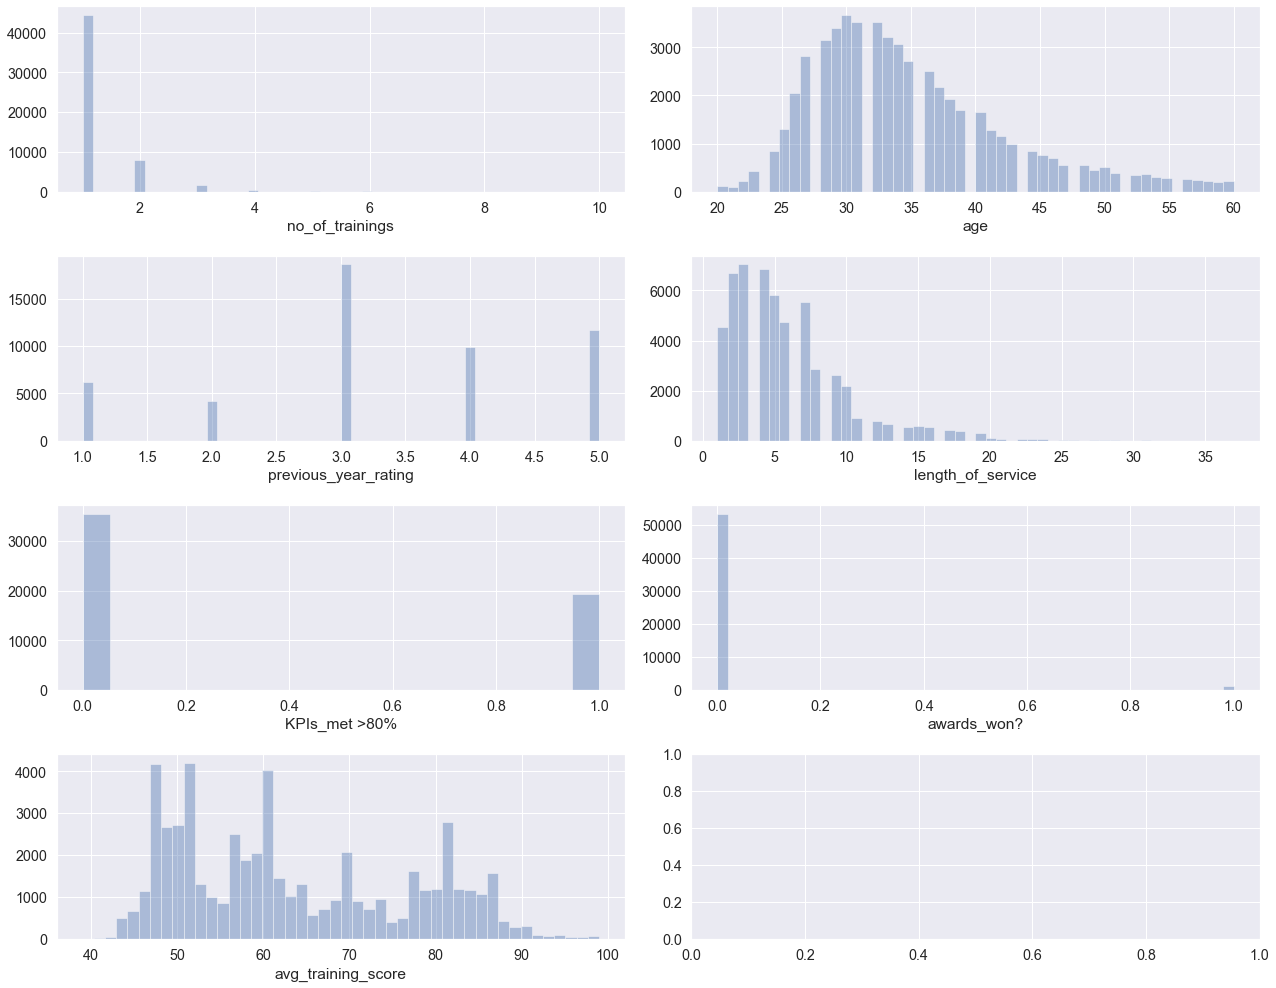

In [516]:
sns.set(font_scale=1.3)
fig, axes = plt.subplots(4, 2, figsize=(18, 14))
axes = [ax for axes_row in axes for ax in axes_row]
for i, c in enumerate(num_cols):
    plot = sns.distplot(train[c], ax=axes[i],kde=False)
plt.tight_layout()

We can deduce the following from the above plots,

1. Age shows slightly positively skewed distribution whereas length of service is positively skewed. 
2. There is no pattern evident from the distribution plot of avg_training_score variable. 
3. We can see that awards_won and KPI_met are binary variables. 
4. We can also see that previous_year_rating and no_of_trainings are kind of categorical in nature although coded numerically. 

#### Correlations

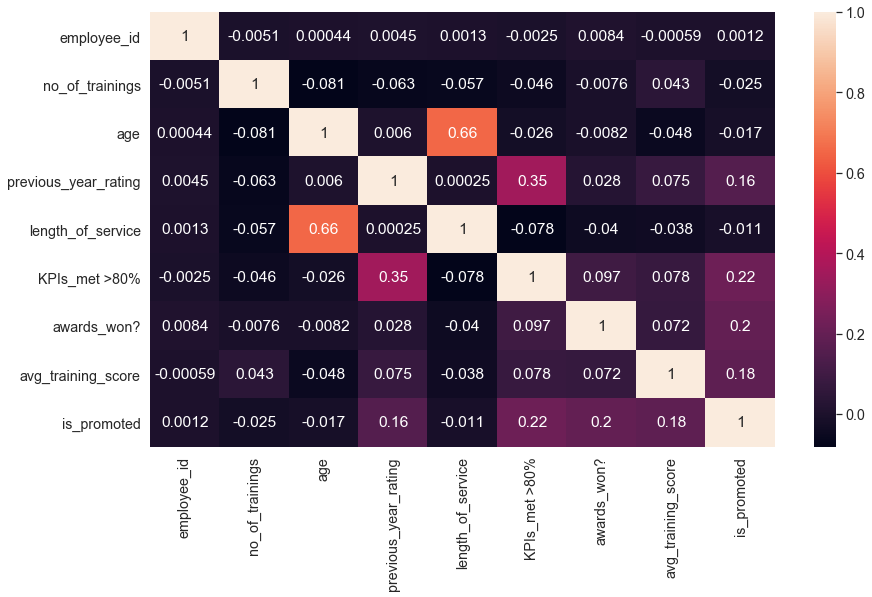

In [517]:
plt.figure(figsize=(14, 8))
_ = sns.heatmap(train.corr(), annot=True)

Following can be deduced from the correlation table above,

1. The dependent variable does not have a high correlation with any of the independent variables.
2. KPI's Met seems to be the one with high correlation with the dependent variable, which is not that high.
3. We can also see that Age and Length_of_service are correlated which is obvious, although the correlation is not very high.
4. We can rule out Multicolleniarity as there is no correlation between independent variables. 

#### Feature Generation 

In [518]:
# Missing value treatment
# we have assumed that the reason previous_year_rating has missing variables is because they have joined this year.

In [519]:
for df in [train,test]:
    df['New_Join'] = np.where(df['previous_year_rating'].isna(),1,0)
    df['previous_year_rating'].fillna(999,inplace=True)
    df['education'].fillna("Missing",inplace=True)

In [520]:
# Since region has high cardinality, we will label encode the variable and create dummy variables for other categotical columns

le = LabelEncoder()
train['region'] = le.fit_transform(train['region'])
test['region'] = le.fit_transform(test['region'])

train = pd.get_dummies(train)
test = pd.get_dummies(test)

In [521]:
# dropping the employee_id variable from the datasets
train.drop("employee_id",axis=1,inplace=True)
test.drop("employee_id",axis=1,inplace=True)

#### Model Building Using sklearn Library

There are two ways of building a Logistic Regression Model in Python, one is using the tandard sklearn library and the other method is using the more conventional statsmodels library. The main disadvantage of using the sklearn library is that it does not provide a detailed output like statsmodels library does, you will know it when you see the statsmodels output below. 

In [522]:
# separating out the dependent and independent variables
X = train[[col for col in train.columns if col!="is_promoted"]]
y = train['is_promoted']

In [523]:
# splitting the data for training and testing purposes
X_Train,X_Test,y_Train,y_Test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)
print (X_Train.shape)
print (y_Train.shape)
print (X_Test.shape)
print (y_Test.shape)

(43846, 27)
(43846,)
(10962, 27)
(10962,)


In [524]:
logreg = LogisticRegression(class_weight='balanced',random_state=42,n_jobs=-1,C=0.5)
logreg.fit(X_Train,y_Train)
train_pred = logreg.predict(X_Train)
test_pred = logreg.predict(X_Test)
print ("Training F1 Score:{}".format(f1_score(y_Train,train_pred)))
print ("Testing F1 Score:{}".format(f1_score(y_Test,test_pred)))

Training F1 Score:0.3338551632167913
Testing F1 Score:0.32913133165253267


In [525]:
# Checking the intercept
logreg.intercept_

array([-2.02504165])

In [526]:
# Checking the coefficients
logreg.coef_

array([[-8.71397613e-03, -3.17439126e-01, -1.06322813e-01,
        -2.90296038e-04,  7.07465244e-02,  1.96677752e+00,
         2.71317775e+00,  1.06595206e-01, -1.26701268e-02,
        -1.89163389e+00, -1.13972476e-01,  4.58166699e-02,
        -2.07049735e-01,  6.00133321e-01, -5.30401140e-01,
        -6.29446262e-01,  1.87833462e+00, -1.17436342e+00,
        -6.02723759e-01, -3.80239632e-01, -1.16678382e-01,
        -9.22940532e-01, -8.52826594e-01, -1.16975571e+00,
        -9.84637894e-01, -2.59373938e-03, -1.03535067e+00]])

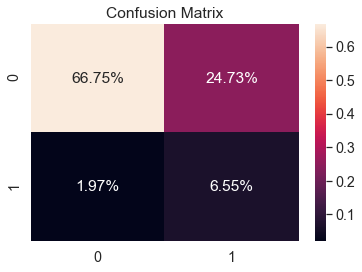

In [527]:
matrix = confusion_matrix(y_Test,test_pred);
sns.heatmap(matrix/np.sum(matrix),annot=True,fmt='.2%');
plt.title("Confusion Matrix");

We can see from the above confusion matrix that,

1. 66.75% of the values are correctly predicted as Not Promoted, this is **True Negatives**.
2. 6.55% of the values are correctly predicted as Predicted, this is **True Positives**.
3. 1.97% of the values are incorrectly predicted as Not Promoted when they are actually promoted, this is **False Negatives**.
4. 24.73% of the values are incorrectly predicted as Promoted when the are Not Promoted, this is **False Positives**. 

Since the evaluation metric for this competition is f1 score, we will understand it with the help of a confusion matrix. F1 score is basically the Harmonic Mean of Precision and Recall, this metric will actually balance between False Negatives and False Positives. 

#### Model Building using statsmodels Library 

In [528]:
import statsmodels.api as sm

In [530]:
X = train[[col for col in train.columns if col!="is_promoted"]]
y = train['is_promoted']

In [531]:
# splitting the data for training and testing purposes
X_Train,X_Test,y_Train,y_Test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)
print (X_Train.shape)
print (y_Train.shape)
print (X_Test.shape)
print (y_Test.shape)

(43846, 27)
(43846,)
(10962, 27)
(10962,)


In [532]:
# building the model and fitting the data 
log_reg = sm.Logit(y_Train, X_Train).fit() 

Optimization terminated successfully.
         Current function value: 0.198569
         Iterations 9


In [533]:
print (log_reg.summary())

                           Logit Regression Results                           
Dep. Variable:            is_promoted   No. Observations:                43846
Model:                          Logit   Df Residuals:                    43822
Method:                           MLE   Df Model:                           23
Date:                Fri, 09 Oct 2020   Pseudo R-squ.:                  0.3181
Time:                        15:55:32   Log-Likelihood:                -8706.5
converged:                       True   LL-Null:                       -12768.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
region                           0.0043      0.002      1.844      0.065      -0.000       0.009
no_of_trainings                 -0.0958      0.039     -2.478      0.013     

In [534]:
# since statsmodels predicts probabilities, we will consider a threshold as 0.5 for the classifier
threshold = 0.5

In [535]:
pred = (log_reg.predict(X_Test)>threshold).apply(int)

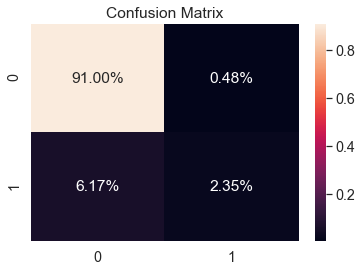

In [536]:
matrix = confusion_matrix(y_Test,pred);
sns.heatmap(matrix/np.sum(matrix),annot=True,fmt='.2%');
plt.title("Confusion Matrix");

We can see from the above confusion matrix that,

1. 91.00% of the values are correctly predicted as Not Promoted, this is **True Negatives**.
2. 2.35% of the values are correctly predicted as Predicted, this is **True Positives**.
3. 6.17% of the values are incorrectly predicted as Not Promoted when they are actually promoted, this is **False Negatives**.
4. 0.48% of the values are incorrectly predicted as Promoted when the are Not Promoted, this is **False Positives**. 

In [538]:
train_pred = (log_reg.predict(X_Train)>threshold).apply(int)
test_pred = (log_reg.predict(X_Test)>threshold).apply(int)
print ("Training F1 Score:{}".format(f1_score(y_Train,train_pred)))
print ("Testing F1 Score:{}".format(f1_score(y_Test,test_pred)))

Training F1 Score:0.39764179711323444
Testing F1 Score:0.4144578313253012


In [539]:
# We can see that statsmodels is actually doing better

We can see above that the statsmodels library displays a detailed output unlike the scikit learn library. The output displayed has the coefficients, probabilities, standard error, confidence intervals which are very useful. Now the way to interpret the coefficients in Logistic Regression is slightly different from Linear Regression, for example, from the above table, consider the KPI's met value, 

When the Length of Service variable met value increases by 1 year, the Log Odds of being promoted increase by a factor of e^(0.0325) = 1.0330 or 3%, so if the lengh of service increases by 1 year, keeping all others constant, the chances of getting promoted increase by 3%.